In [1]:
%%capture
!pip install arabic-stopwords

In [2]:
import pandas as pd
import numpy as np

import re
import arabicstopwords.arabicstopwords as ast
import string
import unicodedata

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score

# Dataset

Dataset consists of tweets belonging to a wide range of country-level Arabic dialects such as Egyptian dialect (EG) , Moroccan Maghrebi dialect (MA), Lybian (LY), Sudanese (SD) and Lebanese (LB), contains 147k tweets.

In [3]:
df = pd.read_csv('/kaggle/input/arabic-ds/arabic_dialect.csv')
df.head()

,Text,Dialect
0,@toha_Altomy @gy_yah قليلين ادب ومنافقين. لو ا...,LY
1,@AlmFaisal 😂😂 الليبيين متقلبين!!!\nبس بالنسبة ...,LY
2,@smsm071990 @ALMOGRBE كل 20 تانيه شاب ليبي بير...,LY
3,@AboryPro @lyranoo85 رانيا عقليتك متخلفة. اولا...,LY
4,@lyranoo85 شكلك متعقدة علشان الراجل لي تحبيه ا...,LY


In [4]:
df.shape

(147725, 2)

## Data splitting

In [5]:
X = df.drop('Dialect',axis=1)
y = df['Dialect']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

In [6]:
# Number of target classes
print('No of Target Dialects:',y.nunique())
print('Dialects are:',y.unique())
#  Egyptian dialect (EG) , Moroccan Maghrebi dialect (MA), Lybian (LY), Sudanese (SD) and Lebanese (LB)

No of Target Dialects: 5
Dialects are: ['LY' 'MA' 'EG' 'LB' 'SD']


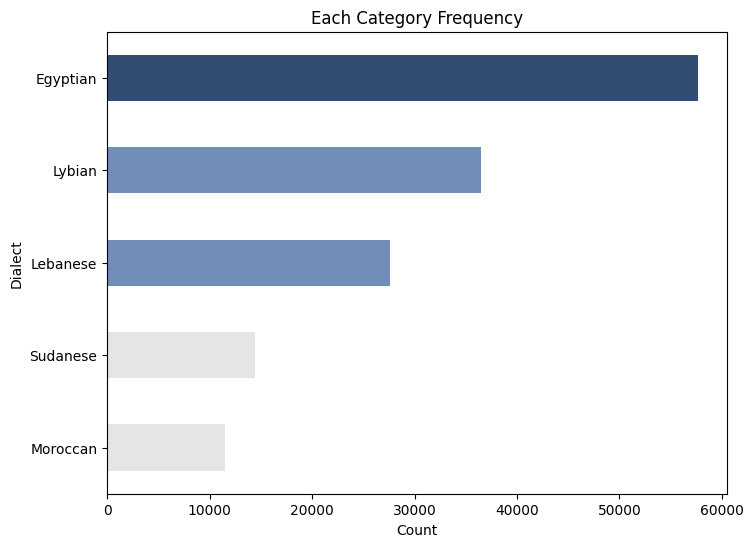

In [7]:
df2 = df.copy()
fig = plt.figure(figsize=(8,6))
colors = ['#e5e5e5','#e5e5e5','#708eb8','#708eb8','#324d72','#324d72']
df2['Dialect'] = df2['Dialect'].map({'LY':'Lybian', 'EG':'Egyptian','MA':'Moroccan','LB':'Lebanese','SD':'Sudanese'})
df2['Dialect'].value_counts().sort_values().plot.barh(color=colors, title= 'Each Category Frequency')
plt.xlabel('Count', fontsize = 10);

In [175]:
df2['Dialect'].value_counts()

Dialect
Egyptian    57636
Lybian      36499
Lebanese    27617
Sudanese    14434
Moroccan    11539
Name: count, dtype: int64


- The dataset shows that the Egyptian dialect has the highest representation, followed by Libyan and Lebanese. 
- The Sudanese and Moroccan dialects have fewer tweets in comparison.

EDA on Training Data

In [176]:
X_train.isna().sum()

Text    0
dtype: int64

In [177]:
X_train.duplicated().sum()

0

The data contains neither duplicates nor nulls.

In [159]:
print('Unique characters: \n',set(''.join((df['Text']).values.astype(str))))

Unique characters: 
 {'👐', 'ﺿ', '♫', '⛏', 'ﮧ', '👾', '🤦', '\u3000', '🥃', 'ل', '\U000e006e', '🛵', 'ﻌ', 'x', '🌶', '🏋', '💁', '🍚', 'ﻵ', '🔁', 'ﺯ', '🇱', '\U000fe552', '⛄', 'ﺇ', '\U000fe358', '🍁', '🔞', '👱', '🍬', '✍', '\ue057', '🏅', '؛', 'ﺱ', '🤓', '父', 'ڭ', '🌎', '😊', '\U000feba0', 'ﮤ', '👽', '💀', '\ue412', '🐄', '🚦', '💸', '\U000fe333', '\u2069', '🐴', '🤝', '➕', ']', '⤵', '🌌', '🐮', '(', 'ﻖ', '🐀', 'ﺹ', '🙎', '😾', 'Ӝ', '🐔', 'ﺍ', '🗡', '📮', '🍟', '🐦', 'ﻃ', '🔛', '🚘', '\u200d', 'な', '☇', 'ڪ', 'إ', '📰', '👢', '🥊', 'ﺅ', '🤬', 'a', '店', '😃', '❓', 'ڈ', '🇹', '🚙', '🧦', 'ع', 'ۡ', '🥑', '📌', 'ﻮ', 'ﺘ', '💎', '天', '~', 'Ƹ', '🐾', 'ﻁ', 'た', '😕', 'и', 'と', '\U000fe1be', '🖒', '’', 'ﻗ', '月', '\U000feb96', '富', '🗝', '⛽', '🌼', '☃', '👝', 'ﺾ', '🏨', 'ツ', '\U000fec00', '黑', 'y', '🤔', '🐢', '🙊', '🐒', '🤮', '🔚', 'ᾰ', '🇸', 'れ', '📀', '🧟', '🚀', '😼', '\U000fe322', '🤾', '🚪', '⬅', '👙', '🕌', 'ف', '1', 'ﺳ', '🛩', 'л', '💫', '单', '\U000fe977', '😢', '港', 'ﺃ', '\U0009fc3d', '\U000fe33f', '🇺', '◾', '🐉', '🌈', '💄', '🐃', '👉', '👫', 'ी', 'ڱ', ')', '√', 

- The dataset contains various symbols and characters that are not relevant to the analysis. 
- These symbols should be removed before further processing or analysis.


## Cleaning and Preprocessing

As we are going to train the dataset using different models , the preprocessing steps may differ based on whether we're fine tuning BERT model or a traditional machine learning model. 

Below are the required preprocessing steps for each approach:

## 1. ML Data Cleaning
Cleaning and preprocessing steps For ML models are:


1. Remove non-Ascii characters like symbols and emojis.

2. Remove usernames 

3. Remove Punctuation

4. Remove English 

5. Handling hashtags

6. Text Normalization

7. Removing elongation

8. Removing Diactritics

9. Removing URLs

10. Remove digits

11. Handling tabs and newlines

12. Removing stopwords

**Note: We won't apply Word Stemmer as arabic stemming is more complex than languages like English due to its rich morphology. Poor stemming algorithms might introduce noise by incorrectly stemming words, which could harm model performance. Also it may induce context loss, because stemming is sometimes strip words down too much, losing important contextual information that might be crucial for distinguishing between dialects.**



In [178]:
def remove_emojis_and_symbols(text):
    # Define the pattern to match emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U000024C2-\U0001F251"
        "\U000fe300-\U000fe3FF"
        "\U000e0060-\U000e0069"
        "\U000fe000-\U000fe999"
        "\U000fe300-\U000fe3FF"
        "\U000feb10-\U000feb99"
        "\U000fe10e-\U000fe1de"
        "\U000feba0-\U000fec99"
        "\U000e006e-\U000e00ff"
        "\u2060-\u2069"
        "\u200a-\u200f"
        "\u061c" 
        "\u23ea"  
        "]+", flags=re.UNICODE
    )
#     pattern = re.compile(r"\b\\[Uu][0-9]+\b")
    return emoji_pattern.sub(r'',text)

# FUNCTION TEST 
text = "\u2066 な👌😍 \U000feb96 重 هلا واللله"
print(f'Before: {text}')
print(f'After :{remove_emojis_and_symbols(text)}')

Before: ⁦ な👌😍 󾮖 重 هلا واللله
After :    هلا واللله


In [179]:
def remove_punctuations(text):
    arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
    english_punctuations = string.punctuation
    punctuations_list = arabic_punctuations + english_punctuations
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

# FUNCTION TEST 
text = "ا, ب, ث, ^ * @ "
print(f'Before: {text}')
print(f'After : {remove_punctuations(text)}')

Before: ا, ب, ث, ^ * @ 
After : ا ب ث    


In [180]:
def remove_english(text):
    english_pattern = re.compile(r'\b[a-zA-Z]+\b')
    cleaned_text = re.sub(english_pattern,'', text)
    
    return cleaned_text

# Example usage:
text = "This is a sample text in English. هذا نص عربي."
print(f'Before: {text}')
print(f'After : {remove_english(text)}')

Before: This is a sample text in English. هذا نص عربي.
After :       . هذا نص عربي.


In [181]:
def remove_digits(text):
    text = re.sub(r'[0-9]+', '', text)  # Remove English digits
    text = re.sub(r'[٠١۲٣٤٥٦٧٨٩]+', '', text)  # Remove Arabic digits
    return text

# FUNCTION TEST 
text = "Hello every1 12233 ٩٤٥٦ 321 هلا واللله"
print(f'Before: {text}')
print(f'After : {remove_digits(text)}')

Before: Hello every1 12233 ٩٤٥٦ 321 هلا واللله
After : Hello every    هلا واللله


In [182]:
def remove_usernames(text):
    pattern = r'\@\S+'     # Remove Usernames
    return re.sub(pattern, r'', text)

# FUNCTION TEST
text = "@user_24233 هلا واللله"
print(f'Before: {text}')
print(f'After :{remove_usernames(text)}')

Before: @user_24233 هلا واللله
After : هلا واللله


In [183]:
def split_hashtags(text):
    
    pattern = r'#\w+'
    hashtags = re.findall(pattern, text)

    for hashtag in hashtags:
        # Remove the '#' symbol and split the remaining text
        hashtag_text = hashtag[1:].replace("_", " ")  # Remove '#' and replace '_' with space
        # Replace the hashtag with the split version in the text
        text = text.replace(hashtag, hashtag_text)
    return text

# FUNCTION TEST 
text = "هلا والله #اهل_الخير"
print(f'Before: {text}')
print(f'After :{split_hashtags(text)}')

Before: هلا والله #اهل_الخير
After :هلا والله اهل الخير


In [184]:
def remove_diactritics(text):
    pattern =  re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida

                         """, re.VERBOSE)
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text


# FUNCTION TEST 
text = "مرحباً بِكُم"
print(f'Before: {text}')
print(f'After : {remove_diactritics(text)}')

Before: مرحباً بِكُم
After : مرحبا بكم


In [185]:
def remove_elongation(text):
    
    pattern = re.compile(r'ـ+')
    # Replace elongation characters with an empty string
    cleaned_text = re.sub(pattern, '', text)
    
    return cleaned_text


# FUNCTION TEST 
text = "مرحبـــــاً بكــــــم في مصـــــرررر"
print(f'Before: {text}')
print(f'After : {remove_elongation(text)}')

Before: مرحبـــــاً بكــــــم في مصـــــرررر
After : مرحباً بكم في مصرررر


In [186]:
def remove_url(text):
    
    pattern = r'ht*ps?://(?:www\.)?\S+'
    return re.sub(pattern,' ',text)


# FUNCTION TEST 
text = " Here's a test link: htps://www.youtube.com/ & https://youtube.com"

print(f'Before: {text}')
print(f'After : {remove_url(text)}')

Before:  Here's a test link: htps://www.youtube.com/ & https://youtube.com
After :  Here's a test link:   &  


In [187]:
def remove_extra_whitespaces(text):
    return re.sub(r"\s+",' ',text)
    
# FUNCTION TEST 
text = 'Hello, How are you\n this is me\n \tI need your help.'
print(f'Before: {text}')
print(f'After : {remove_extra_whitespaces(text)}')

Before: Hello, How are you
 this is me
 	I need your help.
After : Hello, How are you this is me I need your help.


In [188]:
def text_normalize(text):
    
    # Remove redundant letters
    text = re.sub(r'(.)\1+', r"\1", text) 
    
    # Text normalization
    text = re.sub("[إأآااً]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("۽", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("[ڱګگݣڪ]", "ك", text)
    text = re.sub("ڤ", "ف", text)
    text = re.sub("چ", "ج", text)
    text = re.sub("ژ", "ز", text)
    text = re.sub("ڒ", "ز", text)
    text = re.sub("ٺ", "ت", text)
    text = re.sub("پ", "ب", text)
    
    
    return text

# FUNCTION TEST 
text = 'چميل ڱتييييييير'
print(f'Before: {text}')
print(f'After : {text_normalize(text)}')

Before: چميل ڱتييييييير
After : جميل كتير


In [189]:
# Removing Stopwords as they are almost the same in all dialects
stop_words = ast.stopwords_list()
print(stop_words[:8])

['أن', 'أنك', 'أنكما', 'أنكم', 'أنكن', 'أننا', 'أنها', 'أنه']


In [190]:
def remove_stop_words(text):
    stop_words = ast.stopwords_list()
    return ' '.join(word for word in text.split() if word not in stop_words)

# FUNCTION TEST 
text = 'أن أنك أنكما أنكم أنكن أننا أنها أنه'
print(f'Before: {text}')
print(f'After : {remove_stop_words(text)}')

Before: أن أنك أنكما أنكم أنكن أننا أنها أنه
After : 


In [8]:
import unicodedata
class MLTextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.Series):
            # If X is a Pandas Series, apply transformation to each element
            transformed_X = X.copy()
            transformed_X = transformed_X.apply(self.clean_text)
        else:
            # If X is text data, transform it directly
            transformed_X = self.clean_text(X)
            
        self.transformed_X = transformed_X
        return self.transformed_X
    
    def fit_transform(self, X, y=None):
        # This function combines fit and transform
        transformed_X = self.transform(X)
        return transformed_X

    def clean_text(self, text):
        # Remove emojis and symbols
        text = self.remove_emojis_and_symbols(text)
        
        # Remove URLs
        text = self.remove_url(text)
        
        # Unicode Normalization
        text = self.normalize_arabic(text)

        # Split hashtags
        text = self.split_hashtags(text)
        
        # Remove usernames
        text = self.remove_usernames(text)
        
        # Text normalization
        text = self.text_normalize(text)
        
        # Remove diactritics
        text = self.remove_diactritics(text)
        
        # Remove Punctations
        text = self.remove_punctuations(text)
        
        # Remove English
        text = self.remove_english(text)
        
        # Remove Special Characters
        text = self.remove_special_chars(text)
        
        # Remove digits
        text = self.remove_digits(text)

        # Remove elongation characters
        text = self.remove_elongation(text)
        
        # Remove tabs and newlines
        text = self.remove_extra_whitespaces(text)
        
        # Remove stop words
        text = self.remove_stop_words(text)

        return text
    def normalize_arabic(self, text, form='NFC'):
        """
        Normalize Arabic text using Unicode normalization.

        Args:
        - text (str): Input Arabic text.
        - form (str, optional): Unicode normalization form ('NFC' or 'NFD'). Default is 'NFC'.

        Returns:
        - str: Normalized Arabic text.
        """
        normalized_text = unicodedata.normalize(form, text)
        return normalized_text
    
    def remove_emojis_and_symbols(self, text):
        # Define the pattern to match emojis
        emoji_pattern = re.compile(
            "["
            "\U0001F600-\U0001F64F"  # emoticons
            "\U0001F300-\U0001F5FF"  # symbols & pictographs
            "\U0001F680-\U0001F6FF"  # transport & map symbols
            "\U0001F700-\U0001F77F"  # alchemical symbols
            "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
            "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
            "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
            "\U0001FA00-\U0001FA6F"  # Chess Symbols
            "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
            "\U000024C2-\U0001F251"  # Other symbols to remove
            "\U000024C2-\U0001F251"
            "\U000fe300-\U000fe3FF"
            "\U000e0060-\U000e0069"
            "\U000fe000-\U000fe999"
            "\U000fe300-\U000fe3FF"
            "\U000feb10-\U000feb99"
            "\U000fe10e-\U000fe1de"
            "\U000feba0-\U000fec99"
            "\U000e006e-\U000e00ff"
            "\U0009fc0d-\U000febff"
            "\U0001F300-\U0001F6FF"
            "\u2060-\u2069"
            "\u200a-\u200f"
            "\u061c" 
            "\u23ea"  
            "]+", flags=re.UNICODE
        )

        return emoji_pattern.sub(r'', text)

    def split_hashtags(self, text):
        pattern = r'#\w+'
        hashtags = re.findall(pattern, text)
        for hashtag in hashtags:
            # Remove the '#' symbol and split the remaining text
            hashtag_text = hashtag[1:].replace("_", " ")  # Remove '#' and replace '_' with space
            # Replace the hashtag with the split version in the text
            text = text.replace(hashtag, hashtag_text)
        return text
    
    def remove_usernames(self, text):
        pattern = r'\@\S+'
        return re.sub(pattern, r'', text)
    
    def remove_elongation(self, text):
        pattern = re.compile(r'ـ+')
        # Replace elongation characters with an empty string
        return re.sub(pattern, '', text)
    
    def text_normalize(self, text):
        # Remove redundant letters
        text = re.sub(r'(.)\1+', r"\1", text) 

        # Text normalization
        text = re.sub("[إأٱآااً]", "ا", text)
        text = re.sub("ى", "ي", text)
        text = re.sub("ى", "ٸ", text)
        text = re.sub("[ؤٶ]", "ء", text)
        text = re.sub("[ۄۆ]", "و", text)
        text = re.sub("ئ", "ء", text)
        text = re.sub("۽", "ء", text)
        text = re.sub("ڈ", "د", text)
        text = re.sub("ة", "ه", text)
        text = re.sub("[ڱګگݣکڪڳڭ]", "ك", text)
        text = re.sub("ڤ", "ف", text)
        text = re.sub("ڨ", "ف", text)
        text = re.sub("چ", "ج", text)
        text = re.sub("ژ", "ز", text)
        text = re.sub("ڒ", "ز", text)
        text = re.sub("ٺ", "ت", text)
        text = re.sub("پ", "ب", text)

        return text
    
    def remove_stop_words(self, text):
        stop_words = ast.stopwords_list()
        return ' '.join(word for word in text.split() if word not in stop_words)
    
    def remove_digits(self, text):
        text = re.sub(r'[0-9]+', '', text)  # Remove English digits
        text = re.sub(r'[٠١۲٣٤٥٦٧٨٩]+', '', text)  # Remove Arabic digits
        return text
    
    def remove_url(self, text):
        pattern = r'ht*ps?://(?:www\.)?\S+'
        return re.sub(pattern,' ',text)
    
    def remove_diactritics(self, text):
        pattern =  re.compile("""
                                 ّ    | # Tashdid
                                 َ    | # Fatha
                                 ً    | # Tanwin Fath
                                 ُ    | # Damma
                                 ٌ    | # Tanwin Damm
                                 ِ    | # Kasra
                                 ٍ    | # Tanwin Kasr
                                 ْ    | # Sukun
                                 ـ   |  # Tatwil/Kashida

                             """, re.VERBOSE)
        return re.sub(pattern, '', text)
    
    def remove_extra_whitespaces(self, text):
        return re.sub(r"\s+",' ',text)
    
    def remove_punctuations(self, text):
        arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ‼'''
        english_punctuations = string.punctuation
        punctuations_list = arabic_punctuations + english_punctuations
        translator = str.maketrans('', '', punctuations_list)
        return text.translate(translator)
    
    def remove_special_chars(self, text):
        pattern = re.compile(r'[⇸Áäнפ©дےۓǑ⏱Ųлḁ℅ιş¤Ỳतदᾰ₩स₩⑷⌣ыИ②ღŠπƸ£⁉àéáê•тô¿ç™в§йцस«↑עह€и②√Ӝक]+')
        return re.sub(pattern,'', text)
        
    def remove_english(self, text):
        english_pattern = re.compile(r'[a-zA-Z]+')
        return re.sub(english_pattern,'', text)

In [9]:
X_train.reset_index(inplace = True, drop = True)
X_test.reset_index(inplace = True, drop = True)
y_train.reset_index(inplace= True, drop = True)
y_test.reset_index(inplace = True, drop = True)

In [10]:
X_train.head(10)

,Text
0,@ahmedbuz والله بالعكس جو سمح لكن صقع سم لين خلاص
1,@knowwhathappend ضربتها بالقلاية من بكري
2,@momtazahmed14 يا استاذى الفاضل احنا عاصرنا كل...
3,هوينه هانيبال ولد العقيد متزوج لبنانية عارضة أ...
4,@AsmaAhm63626594 @mohamedmhany @Mony4718 @Ahme...
5,@999rejah والله فاصوليا بالكرشة الا باهية الحق 😂
6,شهر رمضان قرب وبدو ايقصو في الضي #كا_العاده
7,الطلاب لوزارة التعليم::اذا مكنشي النهاردة يبقى...
8,@ahmed_cr7_96 السنه هذي ما لعبش كويس لكن حتى ا...
9,@NourOusama يا انت أكل بلوك يا انا اكيد يلي أك...


In [11]:
transformer = MLTextPreprocessor()

cleaned_X_train = transformer.fit_transform(X_train['Text'])
cleaned_X_test = transformer.transform(X_test['Text'])

In [12]:
cleaned_X_train.head(10)

0                   واله بالعكس جو سمح صقع سم لين خلاص
1                                 ضربتها بالقلايه بكري
2        يا استاذي الفاضل احنا عاصرنا ده محدش حكاهولنا
3    هوينه هانيبال ولد العقيد متزوج لبنانيه عارضه ا...
4                       السعاده حضرتك المنشن المحترمين
5                  واله فاصوليا بالكرشه الا باهيه الحق
6                  رمضان قرب وبدو ايقصو الضي كا العاده
7    الطلاب لوزاره التعليماذا مكنشي النهارده يبقي ب...
8             السنه لعبش كويس حتي انا ضد انه يطلع لمسه
9    يا انت اكل بلوك يا انا اكيد يلي اكل بلوك مين هيدا
Name: Text, dtype: object

In [13]:
ML_cleaned_train_ds = pd.DataFrame(pd.concat((cleaned_X_train, y_train), axis = 1))
ML_cleaned_test_ds = pd.DataFrame(pd.concat((cleaned_X_test, y_test), axis = 1))

In [14]:
# Checking for duplicates
print(ML_cleaned_train_ds['Text'].duplicated().sum())
print(ML_cleaned_test_ds['Text'].duplicated().sum())

# Checking for nulls
print(ML_cleaned_train_ds['Text'].isna().sum())
print(ML_cleaned_test_ds['Text'].isna().sum())

166
24
0
0


In [16]:
# Drop duplicated
ML_cleaned_train_ds.drop_duplicates(subset=['Text'], inplace = True)
ML_cleaned_test_ds.drop_duplicates(subset=['Text'], inplace = True)

In [21]:
# Save the cleaned Data
ML_cleaned_train_ds.to_csv('ML_cleaned_train.csv', index=False)
ML_cleaned_test_ds.to_csv('ML_cleaned_test.csv', index=False)


## 2. DL Data Cleaning
When using BERT (Bidirectional Encoder Representations from Transformers), we do not need to perform certain preprocessing steps that are typically done for traditional machine learning models. Here's why:

1. **Punctuation**:
   - BERT is designed to handle raw text, including punctuation. 
   - Punctuation marks often carry important syntactic and semantic information, and removing them could potentially change the meaning of the text. 
   - BERT's tokenization process retains punctuation, allowing the model to learn from it.

2. **English Words**:
   - There's no need to remove English words or any other specific language words before feeding the text into BERT, as ARABert model we're going to use is already trained on some english words that doesn't have a replacement in arabic language such as: Facebook.

3. **Stopwords**:
   -  BERT is capable of learning from the context in which stopwords appear. 
   - Removing stopwords could potentially remove important contextual information that BERT relies on for understanding the text.



Cleaning and preprocessing steps For DL (BERT based model) are:


1. Remove non-Ascii characters like symbols and emojis.

2. Replace usernames

3. Handling hashtags

4. Removing elongation

5. Text Normalization

6. Removing Diactritics

7. Replace URLs

8. Replace digits

9. Handling extra whitespaces and newlines


**Normalization Steps**:
1. **User Mentions**: Replace `@mohamed123` with `@USER`.
2. **Digits**: Replace `5` in `5pm` with `NUM`.
3. **Emojis**: Replace `😊` with `EMOJI`.
4. **URLs**: Replace `https://url.com` with `URL`.

In [130]:
class DLTextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.Series):
            # If X is a Pandas Series, apply transformation to each element
            transformed_X = X.copy()
            transformed_X = transformed_X.apply(self.clean_text)
        else:
            # If X is text data, transform it directly
            transformed_X = self.clean_text(X)
            
        self.transformed_X = transformed_X
        return self.transformed_X
    
    def fit_transform(self, X, y=None):
        # This function combines fit and transform
        transformed_X = self.transform(X)
        return transformed_X

    def clean_text(self, text):
        # Remove emojis and symbols
        text = self.replace_emojis_and_symbols(text)
        
        # Remove URLs
        text = self.replace_url(text)
        
        # Unicode Normalization
        text = self.normalize_arabic(text)
        
        # Split hashtags
        text = self.split_hashtags(text)

        # Remove usernames
        text = self.replace_usernames(text)
        
        # Remove elongation characters
        text = self.remove_elongation(text)
        
        # Remove Special Characters
        text = self.remove_special_chars(text)
        
        # Text normalization
        text = self.text_normalize(text)
        
        # Remove diactritics
        text = self.remove_diactritics(text)
        
        # Remove digits
        text = self.replace_digits(text)
        
        # Remove tabs and newlines
        text = self.remove_extra_whitespaces(text)

        return text
    def normalize_arabic(self, text, form='NFC'):
        """
        Normalize Arabic text using Unicode normalization.

        Args:
        - text (str): Input Arabic text.
        - form (str, optional): Unicode normalization form ('NFC' or 'NFD'). Default is 'NFC'.

        Returns:
        - str: Normalized Arabic text.
        """
        normalized_text = unicodedata.normalize(form, text)
        return normalized_text
    
    def replace_emojis_and_symbols(self, text):
        # Define the pattern to match emojis
        emoji_pattern = re.compile(
            "["
            "\U0001F600-\U0001F64F"  # emoticons
            "\U0001F300-\U0001F5FF"  # symbols & pictographs
            "\U0001F680-\U0001F6FF"  # transport & map symbols
            "\U0001F700-\U0001F77F"  # alchemical symbols
            "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
            "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
            "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
            "\U0001FA00-\U0001FA6F"  # Chess Symbols
            "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
            "\U000024C2-\U0001F251"  # Other symbols to remove
            "\U000024C2-\U0001F251"
            "\U000fe300-\U000fe3FF"
            "\U000e0060-\U000e0069"
            "\U000fe000-\U000fe999"
            "\U000fe300-\U000fe3FF"
            "\U000feb10-\U000feb99"
            "\U000fe10e-\U000fe1de"
            "\U000feba0-\U000fec99"
            "\U000e006e-\U000e00ff"
            "\U0009fc0d-\U000febff"
            "\u2060-\u2069"
            "\u200a-\u200f"
            "\u061c" 
            "\u23ea"  
            "]+", flags=re.UNICODE
        )

        return emoji_pattern.sub(r'EMOJI', text)

    def split_hashtags(self, text):
        pattern = r'#\w+'
        hashtags = re.findall(pattern, text)
        for hashtag in hashtags:
            # Remove the '#' symbol and split the remaining text
            hashtag_text = hashtag[1:].replace("_", " ")  # Remove '#' and replace '_' with space
            # Replace the hashtag with the split version in the text
            text = text.replace(hashtag, hashtag_text)
        return text
    
    def replace_usernames(self, text):
        pattern = r'\@\S+'
        return re.sub(pattern, r'@USER', text)
    
    def remove_elongation(self, text):
        pattern = re.compile(r'ـ+')
        # Replace elongation characters with an empty string
        return re.sub(pattern, '', text)
    
    def text_normalize(self, text):
        # Remove redundant letters
        text = re.sub(r'(.)\1+', r"\1", text) 

        # Text normalization
        text = re.sub("[إأٱآااً]", "ا", text)
        text = re.sub("ى", "ي", text)
        text = re.sub("ى", "ٸ", text)
        text = re.sub("[ؤٶ]", "ء", text)
        text = re.sub("[ۄۆ]", "و", text)
        text = re.sub("ئ", "ء", text)
        text = re.sub("۽", "ء", text)
        text = re.sub("ڈ", "د", text)
        text = re.sub("ة", "ه", text)
        text = re.sub("[ڱګگݣکڪڳڭ]", "ك", text)
        text = re.sub("ڤ", "ف", text)
        text = re.sub("ڨ", "ف", text)
        text = re.sub("چ", "ج", text)
        text = re.sub("ژ", "ز", text)
        text = re.sub("ڒ", "ز", text)
        text = re.sub("ٺ", "ت", text)
        text = re.sub("پ", "ب", text)

        return text
    
    def replace_digits(self, text):
        text = re.sub(r'[0-9]+', 'NUM', text)  # Remove English digits
        text = re.sub(r'[٠١۲٣٤٥٦٧٨٩]+', 'NUM', text)  # Remove Arabic digits
        return text

    def replace_url(self, text):
        pattern = r'ht*ps?://(?:www\.)?\S+'
        return re.sub(pattern,'URL',text)
    
    def remove_diactritics(self, text):
        pattern =  re.compile("""
                                 ّ    | # Tashdid
                                 َ    | # Fatha
                                 ً    | # Tanwin Fath
                                 ُ    | # Damma
                                 ٌ    | # Tanwin Damm
                                 ِ    | # Kasra
                                 ٍ    | # Tanwin Kasr
                                 ْ    | # Sukun
                                 ـ   |  # Tatwil/Kashida

                             """, re.VERBOSE)
        return re.sub(pattern, '', text)
    
    def remove_extra_whitespaces(self, text):
        return re.sub(r"\s+",' ',text)
    
    def remove_special_chars(self, text):
        pattern = re.compile(r'[‹⇸Ùप⑵ब»Áäнפ©дےۓǑ⏱Ųлḁ℅ιş¤Ỳतदᾰ₩स₩⑷⌣ыИ②ღŠπƸ£⁉àéáê•тô¿ç™в§йцस«↑עह€и②√Ӝक]+')
        return re.sub(pattern,'', text)

In [131]:
transformer = DLTextPreprocessor()

cleaned_X_train = transformer.fit_transform(X_train['Text'])
cleaned_X_test = transformer.transform(X_test['Text'])

In [135]:
DL_cleaned_train_ds = pd.DataFrame(pd.concat((cleaned_X_train, y_train), axis = 1))
DL_cleaned_test_ds = pd.DataFrame(pd.concat((cleaned_X_test, y_test), axis = 1))

In [136]:
# Checking for duplicates
print(DL_cleaned_train_ds['Text'].duplicated().sum())
print(DL_cleaned_test_ds['Text'].duplicated().sum())

# Checking for nulls
print(DL_cleaned_train_ds['Text'].isna().sum())
print(DL_cleaned_test_ds['Text'].isna().sum())

14
0
0
0


In [137]:
# Drop duplicated
DL_cleaned_train_ds.drop_duplicates(subset=['Text'], inplace = True)
DL_cleaned_test_ds.drop_duplicates(subset=['Text'], inplace = True)

In [145]:
# Save the cleaned Data
DL_cleaned_train_ds.to_csv('DL_cleaned_train.csv', index=False)
DL_cleaned_test_ds.to_csv('DL_cleaned_test.csv', index=False)

In [144]:
DL_cleaned_train_ds

,Text,Dialect
0,@USER واله بالعكس جو سمح لكن صقع سم لين خلاص,LY
1,@USER ضربتها بالقلايه من بكري,LY
2,@USER يا استاذي الفاضل احنا عاصرنا كل ده محدش ...,EG
3,هوينه هانيبال ولد العقيد متزوج لبنانيه عارضه ا...,LY
4,@USER @USER @USER @USER @USER @USER مساء السعا...,EG
...,...,...
118175,الطريق وانت جاي من تقاطع الاطفال ماشي شور شارع...,LY
118176,@USER الثورجيه ماكدينلي ان مفيش حد غيرهم بيفهم...,EG
118177,الوقت الي تلهو فيه احدهم يصنع من العفسه كنشه,LY
118178,@USER @USER مش ده برضه الجهاز الي قال ان تعداد...,EG
